In this post, I'm going to make a web scraper using `Scrapy` to scrape https://www.themoviedb.org, and use the scraped data to discover which movies and TV shows have the same actors as the ones in my favorite movie, The Help.

# 1. Writing a Scraper Using `Scrapy`

## 1.1 Setting Up

To write a webscraper using `Scrapy`, first navigate to where you want to save your webscraper files on terminal. Then, type the following code in your terminal window. This will initialize your project by creating a series of files for your web scraper. If this is your first time using `Scrapy`, you may want to first install `scrapy` by entering pip install scrapy in your terminal window. 

```
# install scrapy if it's your first time using it
pip install scrapy
```

```
conda activate PIC16B-24F
scrapy startproject TMDB_scraper
cd TMDB_scraper
```

Now, navigate to `settings.py` and add the following line. This line is implemented to prevent your scraper from downloading too many files while you're still testing your scraper. You can remove this line after you're done testing and implementing your web scraper.

In [ ]:
CLOSESPIDER_PAGECOUNT = 20

## 1.2 Creating a Spider

We'll now create a spider to crawl (follow links) the [page](https://www.themoviedb.org/movie/50014-the-help) of my favorite movie and extract data. In `scrapy`, spiders are classes that defines how a site will be scraped. You can read more about it on its [official documentation](https://www.google.com/url?sa=t&source=web&rct=j&opi=89978449&url=https://docs.scrapy.org/en/2.11/topics/spiders.html%23:~:text%3DSpiders%2520are%2520classes%2520which%2520define,pages%2520(i.e.%2520scraping%2520items).&ved=2ahUKEwiX0YeFqb-JAxULLkQIHcKzAsgQFnoECBkQAw&usg=AOvVaw2LrYOrP8VJkFEHJ7eFEqwM).

First, create a file inside the `spiders` directory and name it `tmdb_spider.py`. Then, add the following lines to `tmdb_spider.py`.

In [4]:
import scrapy

class TmdbSpider(scrapy.Spider):
    name = 'tmdb_spider'    # names the spider `tmdb_spider`
    def __init__(self, subdir="", *args, **kwargs):
        self.start_urls = [f"https://www.themoviedb.org/movie/{subdir}/"]

To run the spider, you can run the following command on your terminal window. Feel free to replace the content in `subdir=` with the subdirectory of your favorite TV show or movie from the TMDB website!

```
scrapy crawl tmdb_spider -o movies.csv -a subdir=50014-the-help
```

Note that many websites will set up mechanisms to prevent users from using a Scrapy spider on their website by returning a *403 Error*. To prevent this error from happening, we we can implement a fake user-agent in `settings.py`. Now, navigate to `settings.py` in your TMDB_scraper folder, add the following line: 

In [3]:
# settings.py

USER_AGENT = 'Mozilla/5.0 (iPad; CPU OS 12_2 like Mac OS X) AppleWebKit/605.1.15 (KHTML, like Gecko) Mobile/15E148'

## 1.3 Implementing Parsing Methods

We'll now define three parsing methods for the `TmdbSpider` class.

Our first parsing method, `parse(self, response)`, will navigate from a movie page on themoviedb.org to the Full Cast & Crew page. Instead of returning anything, this function will yield a `scrapy.Request`, and specifies `parse_full_credits()` as the callback. This callback function, parse_full_credits, will handle the response from the cast page and is responsible for processing the cast information.

Here's what the function looks like:

In [10]:
#| echo: false
#| output: true
from TMDB_scraper.TMDB_scraper.spiders.tmdb_spider import TmdbSpider
import inspect
spider = TmdbSpider()
print(inspect.getsource(spider.parse))

    def parse(self, response):
        """starting from a movie page on themoviedb.org, navigates to the Full Cast & Crew page

        i.e. starting from f"https://www.themoviedb.org/movie/{subdir}"
               go to f"https://www.themoviedb.org/movie/{subdir}/cast"

        Args:
            self (Spider): the instance of the spider calling this method
            response (scrapy.http.Response): the response object containing the movie page data, 
                                            from which the cast page URL will be derived and followed.
        """

        # to get url for Full Cast & Crew page
        cast_url = self.start_urls[0] + "cast"

        # navigates to Full Cast & Crew page
        yield scrapy.http.Request(url = cast_url, 
                                    callback = self.parse_full_credits)



Then, we'll define our second parsing method, `parse_full_credits(self, response)`. Again, this method will not return anything, but rather yield a scrapy.Response for each actor's page that is reached, and specifies `parse_actor_page` as the callback. 

Here's what the function looks like:

In [11]:
#| echo: false
#| output: true
print(inspect.getsource(spider.parse_full_credits))

    def parse_full_credits(self, response):
        """assuming we start on Full Cast & Crew Page, yields a scrapy.Request for each actor listed on 
            this page

        Args:
            self (Spider): the instance of the spider calling this method
            response (scrapy.http.Response): the response object containing the movie page data, 
                                            from which the cast page URL will be derived and followed.
        """
        # to get a list of all cast names (excluding crew)
        actors =  response.css("ol[class='people credits '] div[class=info] a::attr(href)").getall()

        # yield a scrapy.Request for each actor
        for actor in actors:
            actor_url = "https://www.themoviedb.org" + actor
            yield scrapy.http.Request(url = actor_url,
                                        callback = self.parse_actor_page)



Lastly, we'll implement `parse_actor_page(self, response)`. This method will scrape the page of an actor and extract data regarding each movie=TV show that the actor has worked in an "Acting" role.

Here's what the function looks like:

In [12]:
#| echo: false
#| output: true
print(inspect.getsource(spider.parse_actor_page))

    def parse_actor_page(self, response):
        """assuming we start on page of an actor, scrapes page to get data regading each movie/TV show that
            actor has worked in an "Acting" role
        
        Args:
            self (Spider): the instance of the spider calling this method
            response (scrapy.http.Response): the response object containing the movie page data, 
                                            from which the cast page URL will be derived and followed.

        Returns:
            a dictionary containing two key value pairs of the form
                    {"actor": actor_name, "movie_or_TV_name: movie_or_TV_name"}
        """

        # extracting actor name from page
        actor_name = response.css("h2[class=title] a::text").get()  

        # extracting list of all shows/movies actor has been in
        movie_or_TV_name = response.css("a[class=tooltip] bdi::text").getall()
        
        # returning desired dictionary
        yield {"actor

After successfully implementing these methods, you can remove the line `CLOSESPIDER_PAGECOUNT = 20` in `settings.py` and run the following line to export the extracted data into a csv file called `results.csv` in the `TMDB_scraper` directory.

```
scrapy crawl tmdb_spider -o results.csv -a subdir=50014-the-help
```

# 2. Making Recommendations

Here's what the `resuls.csv` should look like!

In [21]:
#| output: true
import pandas as pd
df = pd.read_csv("results.csv")
df.head()

,actor,movie_or_TV_name
0,Lamar Lott,"The Wilderness Road,Ma,Christmas in Mississipp..."
1,Elizabeth Smith,The Help
2,Charles Orr,"Raising Dion,The Best of Enemies,The Final Pro..."
3,Mary Taylor Killebrew,The Help
4,Emma Stone,"Cruella 2,Checkmate,Untitled Dave McCary Film,..."


Let's clean up the dataframe so that we can make interesting visualizations from it!

In [23]:
#| output: true
# Split the 'movie_or_TV_name' column by comma and expand 
#  into multiple rows
df['movie_or_TV_name'] = df['movie_or_TV_name'].str.split(',')
df = df.explode('movie_or_TV_name')

# Remove any leading/trailing whitespace from movie/TV names
df['movie_or_TV_name'] = df['movie_or_TV_name'].str.strip()

# Display the resulting DataFrame
df.head()

,actor,movie_or_TV_name
0,Lamar Lott,The Wilderness Road
0,Lamar Lott,Ma
0,Lamar Lott,Christmas in Mississippi
0,Lamar Lott,Same Kind of Different as Me
0,Lamar Lott,The Hollars


Perfect! Now we're ready to visualize it.

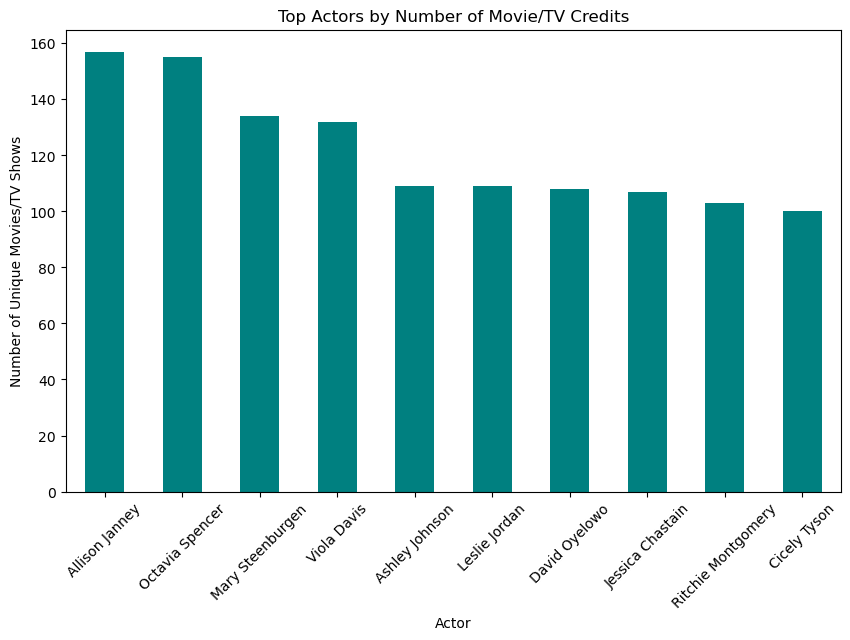

In [24]:
#| output: true
import matplotlib.pyplot as plt

# count movies or TV shows per actor
actor_counts = df.groupby(
    'actor')['movie_or_TV_name'].nunique().sort_values(
        scending=False)

# plot bar chart
plt.figure(figsize=(10, 6))
actor_counts.head(10).plot(kind='bar', color='teal')
plt.xlabel("Actor")
plt.ylabel("Number of Unique Movies/TV Shows")
plt.title("Top Actors by Number of Movie/TV Credits")
plt.xticks(rotation=45)
plt.show()